<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/TP_ADVERSAIRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#deep learning sous attaque adversaire

L'objet de ce TP est de démontrer
- la faciliter de produire des attaques adversaires "white box" sur des réseaux naifs quelles soient invisibles ou par patch
- mais que cela est beaucoup plus dur sur un réseau robustifier (cas invisible)
- ou encore qu'il est beaucoup plus difficile de produire des attaques "transferable"

## generalité

Commençons par télécharger 10 images d'imagenet.

In [ ]:
!rm -f *
!wget https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
!unzip data.zip
!ls

rm: cannot remove 'sample_data': Is a directory
--2024-09-24 17:46:18--  https://httpmail.onera.fr/21/500df56b6a7a034ecc2f3e0345f1ce9cYqsE3G/data.zip
Resolving httpmail.onera.fr (httpmail.onera.fr)... 144.204.16.9
Connecting to httpmail.onera.fr (httpmail.onera.fr)|144.204.16.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723589 (707K) [application/force-download]
Saving to: ‘data.zip’

data.zip            100%[===================>] 706.63K   812KB/s    in 0.9s    

2024-09-24 17:46:19 (812 KB/s) - ‘data.zip’ saved [723589/723589]

Archive:  data.zip
 extracting: 0.png                   
  inflating: 1.png                   
 extracting: 2.png                   
 extracting: 3.png                   
  inflating: 4.png                   
 extracting: 5.png                   
 extracting: 6.png                   
 extracting: 7.png                   
 extracting: 8.png                   
 extracting: 9.png                   
0.png  1.png  2.png  3.png  4.png 

Affichons les : les 5 premières sont des "avions" et les 5 suivantes des "requins"

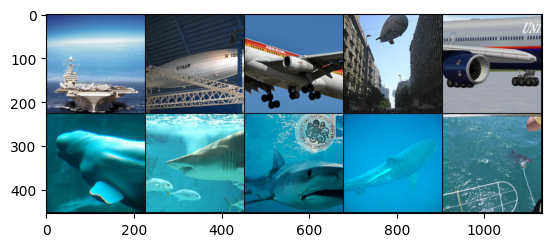

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

x = [torchvision.io.read_image(str(i)+".png") for i in range(10)]
x = torch.stack(x,dim=0).float()/255

visu = torchvision.utils.make_grid(x, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()

In [ ]:
SHARK, PLANE = [2, 3, 4], [403, 404, 405]
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
resnet = torchvision.models.resnet101(
    weights=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
).eval()

with torch.no_grad():
    z = resnet(normalize(x))
    _,z = z.max(1)
    print(z)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:05<00:00, 35.5MB/s]


tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2])


On voit que le réseau classe correctement ces images.

## Attaque

On va maintenant rajouter à ces images un petit bruit "invisible" pour l'oeil mais perturbant pour le réseau.

In [ ]:
y = torch.Tensor([403, 405, 404, 405, 404,   4,   3,   3,   3,   2]).long()

cefunction = torch.nn.CrossEntropyLoss()
attaque = torch.zeros(x.shape)

for j in range(y.shape[0]):
    print(j)
    optimizer = torch.optim.SGD([attaque],lr=0.01)
    xtmp = x[j].view(1,3,224,224)
    ytmp = (y[j]*torch.ones(1)).long()
    atmp = torch.nn.Parameter(torch.zeros(1,3,224,224, requires_grad=True))
    for i in range(40):
      z = resnet(normalize(xtmp+atmp))
      ce = cefunction(z,ytmp)
      if i%5==4:
          print(i,float(ce))
      ce = -ce # on veut MAXIMISER la cross entropy puisqu'on attaque
      optimizer.zero_grad()
      ce.backward()
      optimizer.step()
      with torch.no_grad():
          # l'attaque doit être invisible
          atmp = torch.clamp(atmp, -10./255,+10./255)

          # attaque+x doit être entre 0 et 1
          lowbound = -xtmp
          uppbound = 1-xtmp
          atmp = lowbound*(atmp<lowbound).float() + uppbound*(atmp>uppbound).float() + atmp *(atmp>=lowbound).float()*(atmp<=uppbound).float()

          attaque[j]=atmp.clone()

      atmp = torch.nn.Parameter(atmp.clone())
      optimizer = torch.optim.SGD([atmp],lr=0.01)


with torch.no_grad():
    z = resnet(normalize(x+attaque))
    _,z = z.max(1)
    print(z)

0
0 0.0018294993788003922
1 0.0014784131199121475
2 0.0015012671938166022
3 0.001524953986518085
4 0.0015493544051423669
5 0.001574111171066761
6 0.0015997005393728614
7 0.0016264794394373894
8 0.0016538526397198439
9 0.0016814630944281816
10 0.0017100248951464891
11 0.0017389428103342652
12 0.0017690499080345035
13 0.0018005840247496963
14 0.001833664020523429
15 0.0018681708024814725
16 0.001904818112961948
17 0.0019422968616709113
18 0.0019813207909464836
19 0.0020216519478708506
20 0.002063765889033675
21 0.002107305685058236
22 0.0021526277996599674
23 0.002198899397626519
24 0.002247072057798505
25 0.0022971450816839933
26 0.0023481673561036587
27 0.0024026355240494013
28 0.002458765869960189
29 0.002517271088436246
30 0.0025774375535547733
31 0.002640453865751624
32 0.0027059626299887896
33 0.002774082822725177
34 0.0028461208567023277
35 0.0029199367854744196
36 0.0029963618144392967
37 0.00307598989456892
38 0.003162028733640909
39 0.0032507930882275105
1
0 0.07139665633440018

KeyboardInterrupt: 

Les images "x+attaque" sont désormais mal classées !
Pourtant, l'attaque ne se voit pas :

In [ ]:
with torch.no_grad():
    z = resnet(normalize(x+attaque))
    _,z = z.max(1)
    print(z)

visu = torchvision.utils.make_grid(x+attaque, nrow=5)
plt.imshow(visu.permute(1, 2, 0).numpy())
plt.show()